####Preparación entorno

Torchxrayvision es una libreria para conjuntos de datos y modelos de rayos X
https://github.com/mlmed/torchxrayvision





In [1]:
!pip install torchxrayvision

from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 42.4MB 71kB/s 
     |████████████████████████████████| 1.9MB 42.4MB/s 
Mounted at /content/gdrive


####Librerías

In [2]:
import pandas as pd
import numpy as np

import torch
import torchvision
import torchxrayvision as xrv
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as ts

from os.path import isfile, join
from os import listdir

import matplotlib.pyplot as plt

#get convolutional layer
from fastai.vision import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

####Funciones

#####Función para sintetizar las clases

In [3]:
#Separa la columna finding y coloca como clase su último elemento
def class_filter (str):
  arr = str.split('/')
  return arr[-1:][0]

#####Función de Binarización

In [4]:
#Separa la columna finding de forma binaria
def class_bin (str):
  arr = str.split('/')
  return 'COVID-19' if arr[-1:][0] == 'COVID-19' else 'NO-COVID'

#####Función de Entrenamiento del Modelo

In [5]:
def train(model, optimizer, epoch, dataloader):
  
  model.train() # Modo entrenamiento
  n_correct = 0
  train_loss = 0

  # Iteramos sobre la lista de batches
  for batch, data in enumerate(dataloader,1): 

    img = data['img'].to(device)
    target = data['lab'].long().to(device)
    _, labels = torch.max(target,1) # Retorna dos valores: value, index

    #resizing process: (temp_batch_size, chanel_base_on_NN, picY1, picX1)
    img.resize_((_.shape[0], 3, resizer_value, resizer_value))
    
    # Realizar para forward-backward
    outputs = model(img)      
    _, predictions = torch.max(outputs,1)
    loss = F.cross_entropy(outputs, labels)        
    loss.backward()
    optimizer.step()    
    optimizer.zero_grad()

    # train_loss += loss.item()
    # n_correct += (predictions == labels).sum().item()

    if batch % log_interval == 0:
      print(f'Train epoch: {epoch}\t'
            f'Batch: {batch} [{batch*len(img)}/{len(dataloader.dataset)}'
            f' ({100.*batch/len(dataloader):.0f}%)]\t'
            f'Loss: {loss.item():.6f}')
      
      train_losses.append(loss.item())
      train_counter.append((batch*batch_size) + ((epoch-1)*len(dataloader.dataset)))
      torch.save(model.state_dict(),'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
    
  # train_loss /= len(dataloader.dataset)
  # acc = 100.*n_correct/len(dataloader.dataset)

  # print(f'\nTest set: Avg. Loss: {train_loss:.4f}'
  #       f', Accuracy: {n_correct}/{len(dataloader.dataset)}'
  #       f' ({acc:.2f}%)\n')  

#####Función de Test del Modelo

In [6]:
def test(model, dataloader):
  model.eval() # Modo test, para que no se compute la gradiente
  n_correct = 0
  test_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader):

      img = data['img'].to(device)
      target = data['lab'].long().to(device)
      _, labels = torch.max(target,1) # Retorna dos valores: value, index

      #resizing process: (temp_batch_size, chanel_base_on_NN, picY1, picX1)
      img.resize_((_.shape[0], 3, resizer_value, resizer_value))

      outputs = model(img)      
      _, predictions = torch.max(outputs,1)

      test_loss += F.cross_entropy(outputs, labels).item()
      n_correct += (predictions == labels).sum().item()

  test_loss /= len(dataloader.dataset)
  test_losses.append(test_loss)
  acc = 100.*n_correct/len(dataloader.dataset)

  print(f'\nTest set: Avg. Loss: {test_loss:.4f}'
        f', Accuracy: {n_correct}/{len(dataloader.dataset)}'
        f' ({acc:.2f}%)\n')

####Clases

#####Modelo CNN-Base

In [7]:
class CNN(nn.Module):

  def __init__(self):
    
    #Inicialización

    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=55, padding=1)  
    self.conv2 = nn.Conv2d(16, 32, kernel_size=27, padding=1) 
    self.conv3 = nn.Conv2d(32, 64, kernel_size=13)

    self.fc1 = nn.Linear(in_features=64*19*19, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features = 23)
  
  def forward(self, x):

    #Paso forward

    x = F.relu(F.max_pool2d(self.conv1(x),kernel_size=2)) #Max pooling, divide la dimensión entre 2
    #print('shape 0 ' + str(x.shape))
    x = F.relu(F.max_pool2d(self.conv2(x),kernel_size=2))
    #print('shape 1 ' + str(x.shape))
    x = F.relu(self.conv3(x)) #x = (64,19,19) volumen
    #print('shape 2 ' + str(x.shape))
    x = x.view(-1, 19*19*64) #Se lineariza
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return F.log_softmax(x, dim=1) #Todas las probabilidades deben sumar dim = 1

#####Modelo DarkCovidNet

In [8]:
class DCovidNet(object):

  def __init__(self):
    pass
    
  def conv_block(self, ni, nf, size=3, stride=1):
      
      #padding auto definition
      for_pad = lambda s: s if s > 2 else 3
      
      return nn.Sequential(
          nn.Conv2d(
              ni, nf, 
              kernel_size=size, 
              stride=stride, 
              padding=(for_pad(size) - 1)//2, bias=False), 
          #batch normalization
          nn.BatchNorm2d(nf),
          #leaky reLu to avoid dying Neurons phenomena
          nn.LeakyReLU(negative_slope=0.1, inplace=True)  
      )

  def triple_conv(self, ni, nf):
      return nn.Sequential(
          self.conv_block(ni, nf),
          self.conv_block(nf, ni, size=1),  
          self.conv_block(ni, nf)
      )  

  def maxpooling(self):
      return nn.MaxPool2d(2, stride=2)

  def convolutionalNetwork(self):
    
    model_dkn = nn.Sequential(
          self.conv_block(3, 8),
          self.maxpooling(),
          self.conv_block(8, 16),
          self.maxpooling(),
          self.triple_conv(16, 32),
          self.maxpooling(),
          self.triple_conv(32, 64),
          self.maxpooling(),
          self.triple_conv(64, 128),
          self.maxpooling(),
          self.triple_conv(128, 256),
          self.conv_block(256, 128, size=1),
          self.conv_block(128, 256),
          conv_layer(256, 2),
          Flatten(),
          nn.Linear(338, 2)
      )    
    
    return model_dkn

def DarkCovidNet():
  return DCovidNet().convolutionalNetwork()

####Parámetros

In [9]:
# Parámetros de entrenamiento
##############################

num_epochs = 50          #Número de épocas de entrenamiento
batch_size = 25         #Cada cuantos ejemplos se va a iterar para el entrenamiento
momentum = 0.5          #Para la gradiente estocastica
log_interval = 10       #Cada cuantos batch se imprime log
learning_rate = 0.001    #Ratio de entrenamiento
resizer_value = 256

#Rutas
##############################

path_images = '/content/gdrive/MyDrive/Colab Notebooks/Diplomado - Trabajo Vision Artificial/COVID_FILTERED_PICTURES'
path_meta = '/content/gdrive/MyDrive/Colab Notebooks/Diplomado - Trabajo Vision Artificial/new_metadata.csv'

####Limpieza de la Metadata

In [10]:
meta = pd.read_csv(path_meta)
onlyfiles = [f for f in listdir(path_images) if isfile(join(path_images, f))]

meta_filt = pd.concat([meta['view'],meta['finding'],meta['filename']],axis=1)
meta_filt = meta_filt[meta_filt['filename'].isin(onlyfiles)]

#Funcion que altera la columna de clase
meta_filt['finding'] = np.vectorize(class_bin)(meta_filt['finding'])

#almacenamos la data en un csv
meta_filt.to_csv('metadata_filt.csv')

####Obtención del Dataset

In [11]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(resizer_value)])

dataset = xrv.datasets.COVID19_Dataset(imgpath= path_images, 
                                         csvpath= 'metadata_filt.csv', 
                                         views= ["PA", "AP", "AP Supine"],
                                         transform=transform)
dataset.csv.head()

,index,Unnamed: 0,view,finding,filename
0,0,0,PA,COVID-19,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,1,1,PA,COVID-19,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,2,2,PA,COVID-19,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,3,3,PA,COVID-19,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,4,4,PA,COVID-19,nejmc2001573_f1a.jpeg


In [12]:
#Verificación de la etiqueta y la patología
print('Descripción del dataset:')
print('*'*30)
print(dataset.csv['finding'].describe())
print('\nResumen de las clases:')
print('*'*30)
print(dataset.csv['finding'].value_counts())

Descripción del dataset:
******************************
count         1840
unique           2
top       NO-COVID
freq          1225
Name: finding, dtype: object

Resumen de las clases:
******************************
NO-COVID    1225
COVID-19     615
Name: finding, dtype: int64


####Separación de Datos de Train y Test

In [13]:
#Obtenemos la distribución de entrenamiento y pruebas
#####################################################

len_dataset=len(dataset)
n_train=int(0.8*len_dataset)
n_test=int(0.2*len_dataset)+(len_dataset%2)
print(f'Total samples: {len_dataset}, train size size: {n_train}, test set size: {n_test}')

Total samples: 1840, train size size: 1472, test set size: 368


In [14]:
train_ds, test_ds = torch.utils.data.random_split(dataset, [n_train,n_test])
train_dl = torch.utils.data.DataLoader(dataset = train_ds, batch_size=batch_size,shuffle=True, num_workers=5)
test_dl = torch.utils.data.DataLoader(dataset = test_ds, batch_size=batch_size,shuffle=True, num_workers=1)

####Visualización de conjunto de entrenamiento

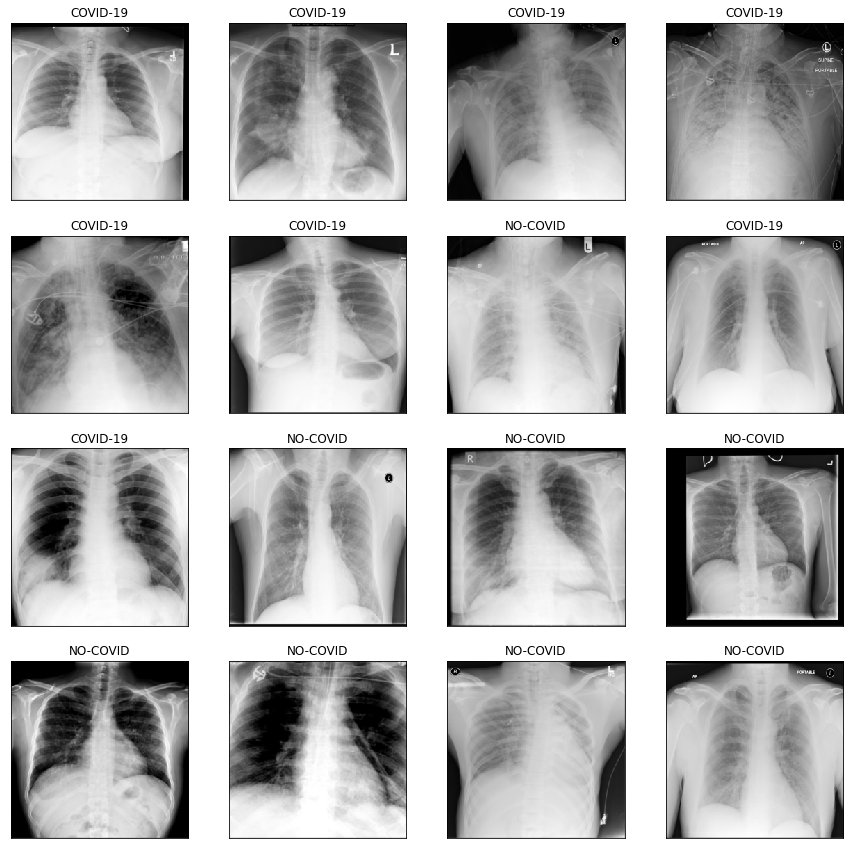

In [15]:
plt.figure(figsize=(15,15))
for i in range(16):
  img = torch.from_numpy(train_dl.dataset[i]['img'][0])
  label = train_dl.dataset[i]['lab']
  label_name = dataset.csv.iloc[i]['finding']
  plt.subplot(4,4,i+1)
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.title(f'{label_name}')
  plt.xticks([])
  plt.yticks([])

####Inicializamos el modelo

In [ ]:
model = DarkCovidNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

####Resumen del modelo generado

In [ ]:
#print(model)
ts.summary(model,(3, resizer_value,resizer_value)) #Importante colocar número de canales de entrada

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             216
       BatchNorm2d-2          [-1, 8, 256, 256]              16
         LeakyReLU-3          [-1, 8, 256, 256]               0
         MaxPool2d-4          [-1, 8, 128, 128]               0
            Conv2d-5         [-1, 16, 128, 128]           1,152
       BatchNorm2d-6         [-1, 16, 128, 128]              32
         LeakyReLU-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           4,608
      BatchNorm2d-10           [-1, 32, 64, 64]              64
        LeakyReLU-11           [-1, 32, 64, 64]               0
           Conv2d-12           [-1, 16, 66, 66]             512
      BatchNorm2d-13           [-1, 16, 66, 66]              32
        LeakyReLU-14           [-1, 16,

####Entrenamiento y Verificación del Modelo

In [ ]:
print(f'Elementos en dataset: {len(train_dl.dataset)}')
print(f'Elementos en batch: {batch_size}')
print(f'Cantidad de batches: {len(train_dl.dataset)/batch_size}')

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dl.dataset) for i in range(num_epochs+1)]

test(model,test_dl)
for epoch in range(1, num_epochs + 1):
  train(model, optimizer, epoch, train_dl)
  test(model,test_dl)

Elementos en dataset: 624
Elementos en batch: 25
Cantidad de batches: 24.96

Test set: Avg. Loss: 0.0306, Accuracy: 102/157 (64.97%)

Train epoch: 1	Batch: 10 [250/624 (40%)]	Loss: 0.689071
Train epoch: 1	Batch: 20 [500/624 (80%)]	Loss: 0.811989

Test set: Avg. Loss: 0.0290, Accuracy: 100/157 (63.69%)

Train epoch: 2	Batch: 10 [250/624 (40%)]	Loss: 0.727320
Train epoch: 2	Batch: 20 [500/624 (80%)]	Loss: 0.628420

Test set: Avg. Loss: 0.0296, Accuracy: 102/157 (64.97%)

Train epoch: 3	Batch: 10 [250/624 (40%)]	Loss: 0.659923
Train epoch: 3	Batch: 20 [500/624 (80%)]	Loss: 0.698824

Test set: Avg. Loss: 0.0283, Accuracy: 102/157 (64.97%)

Train epoch: 4	Batch: 10 [250/624 (40%)]	Loss: 0.735478
Train epoch: 4	Batch: 20 [500/624 (80%)]	Loss: 0.744293

Test set: Avg. Loss: 0.0300, Accuracy: 99/157 (63.06%)

Train epoch: 5	Batch: 10 [250/624 (40%)]	Loss: 0.792610
Train epoch: 5	Batch: 20 [500/624 (80%)]	Loss: 0.592180

Test set: Avg. Loss: 0.0297, Accuracy: 98/157 (62.42%)

Train epoch: 6	Bat

In [16]:
#se selecciona el modelo
tr_model = models.alexnet(pretrained=True)

#a cada uno de los parametros se le quita la posibilidad de que recalcule las gradientes
for param  in tr_model.parameters():
  param.requires_grad=False

tr_model.classifier[6] = nn.Linear(4096,2)
tr_model=tr_model.to(device)

#se crea los hiperparametros
tr_criterion = nn.CrossEntropyLoss()

tr_optimizer=torch.optim.Adam(tr_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

#tr_optimizer = torch.optim.SGD(tr_model.parameters(), lr=0.001, momentum=0.9)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_value)
#tr_optimizer = torch.optim.Rprop(tr_model.parameters(), lr=0.001, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dl.dataset) for i in range(num_epochs+1)]

print(f'Elementos en dataset: {len(train_dl.dataset)}')
print(f'Elementos en batch: {batch_size}')
print(f'Cantidad de batches: {len(train_dl.dataset)/batch_size}')

test(tr_model,test_dl)
for epoch in range(1, num_epochs + 1):
  train(tr_model, tr_optimizer, epoch, train_dl)
  test(tr_model,test_dl)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Elementos en dataset: 1472
Elementos en batch: 25
Cantidad de batches: 58.88

Test set: Avg. Loss: 1.7202, Accuracy: 157/368 (42.66%)

Train epoch: 1	Batch: 10 [250/1472 (17%)]	Loss: 15.904779
Train epoch: 1	Batch: 20 [500/1472 (34%)]	Loss: 8.136024
Train epoch: 1	Batch: 30 [750/1472 (51%)]	Loss: 10.818350
Train epoch: 1	Batch: 40 [1000/1472 (68%)]	Loss: 9.462381
Train epoch: 1	Batch: 50 [1250/1472 (85%)]	Loss: 40.457481

Test set: Avg. Loss: 1.2082, Accuracy: 260/368 (70.65%)

Train epoch: 2	Batch: 10 [250/1472 (17%)]	Loss: 19.795385
Train epoch: 2	Batch: 20 [500/1472 (34%)]	Loss: 8.736743
Train epoch: 2	Batch: 30 [750/1472 (51%)]	Loss: 26.426525
Train epoch: 2	Batch: 40 [1000/1472 (68%)]	Loss: 7.567788
Train epoch: 2	Batch: 50 [1250/1472 (85%)]	Loss: 18.855963

Test set: Avg. Loss: 0.2533, Accuracy: 239/368 (64.95%)

Train epoch: 3	Batch: 10 [250/1472 (17%)]	Loss: 18.226818
Train epoch: 3	Batch: 20 [500/1472 (34%)]	Loss: 6.948313
Train epoch: 3	Batch: 30 [750/1472 (51%)]	Loss: 13.48

#### Visualización con predicción

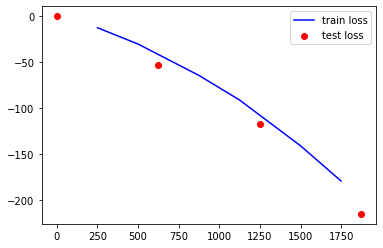

In [ ]:
plt.figure()
plt.plot(train_counter, train_losses, color='blue', label='train loss')
plt.scatter(test_counter, test_losses, color='red', label='test loss')
plt.legend()
plt.show()

####Probamos el modelo

In [ ]:
batch = next(iter(test_dl)) #Test loader es un elemento iterable

images = batch['img'].to(device)
targets = batch['lab'].long().to(device)
_, labels = torch.max(targets,1)

images.resize_((_.shape[0], 3, resizer_value, resizer_value))

with torch.no_grad():
  outputs = model(images)
_, predictions = torch.max(outputs,1)

images.resize_((_.shape[0], 1, resizer_value, resizer_value))

plt.figure(figsize=(15,15))
for n in range(6):
  plt.subplot(3,3,n+1)
  plt.imshow(images[n].permute(1,2,0).squeeze().cpu().numpy(), cmap='gray', interpolation='none')
  plt.title(f'{dataset.pathologies[labels[n]]}:{dataset.pathologies[predictions[n]]}')
  plt.xticks([])
  plt.yticks([])